In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


2022-05-27 04:28:48.941541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-27 04:28:48.941572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataframe1 = pd.read_csv("../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_IoT_dataset/Train_Test_IoT_Modbus.csv")
#dataframe2 = pd.read_csv("./datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_IoT_dataset/Train_Test_IoT_Weather.csv")
raw_data1 = dataframe1.values
#raw_data2 = dataframe2.values

In [3]:
data = raw_data1[:, 3:6]
labels = raw_data1[:, -2]

#data = raw_data2[:, 3:5]
#labels = raw_data2[:, -2]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=21)

In [4]:
# len(labels[labels>0]) #16106
# len(labels[labels==0]) #35000


Normalize:

In [5]:
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


2022-05-27 04:28:54.653718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-27 04:28:54.654833: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-27 04:28:54.655186: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2022-05-27 04:28:54.670747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Separate normal and abnormal classes

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]


Plot a normal and an abnormal modbus

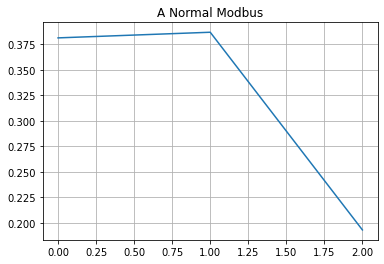

In [7]:
plt.grid()
plt.plot(np.arange(3), normal_train_data[0])
plt.title("A Normal Modbus")
plt.show()


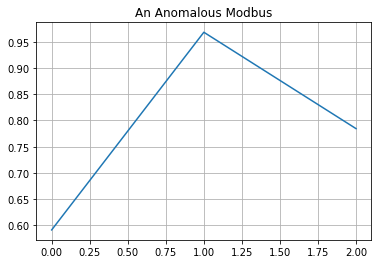

In [8]:
plt.grid()
plt.plot(np.arange(3), anomalous_train_data[0])
plt.title("An Anomalous Modbus")
plt.show()

### Build the model - OVERCOMPLETE AE
Dont use mean squared error in classification; cross entropy yes. However, training the AE with just normal data is not a classification task

In [9]:
#class AnomalyDetector(Model):
#  def __init__(self):
#    super(AnomalyDetector, self).__init__()
#    self.encoder = tf.keras.Sequential([
#      layers.Dense(64, activation="relu"),
#      layers.Dense(32, activation="relu"),
#      layers.Dense(16, activation="relu"),
#      layers.Dense(8, activation="relu")])

#    self.decoder = tf.keras.Sequential([
#      layers.Dense(16, activation="relu"),
#      layers.Dense(32, activation="relu"),
#      layers.Dense(64, activation="relu"),
#      layers.Softmax()])
      #layers.Dense(3, activation="sigmoid")])

#  def call(self, x):
#    encoded = self.encoder(x)
#    decoded = self.decoder(encoded)
#    return decoded

#autoencoder = AnomalyDetector()


In [10]:
#autoencoder.compile(optimizer='adam', loss='MeanSquaredError', metrics=[tf.keras.metrics.BinaryAccuracy()])

Regular training with all training instances

In [12]:
#history = autoencoder.fit(train_data, train_labels, 
#          epochs=1, 
#          batch_size=1,
#          validation_data=(test_data, test_labels),
#          shuffle=True)


34241/34241 [==============================] - 46s 1ms/step - loss: 1.9345 - binary_accuracy: 0.6801 - val_loss: 1.9476 - val_binary_accuracy: 0.6771


### Training the AE with normal data

In [11]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(3, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()


In [12]:
autoencoder.compile(optimizer='adam', loss='mae')

The training is just performed with normal instance. However, test is done with all the instances.

In [13]:
# USAGE OF TEST DATA TO VAL NOT FAIR
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50,
          batch_size=32,
          validation_data=(test_data, test_data),
          shuffle=True)


Epoch 1/50
734/734 [==============================] - 2s 2ms/step - loss: 0.0655 - val_loss: 0.0182
Epoch 2/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 3/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0116
Epoch 4/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0087
Epoch 5/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 6/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0101
Epoch 7/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 8/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0085
Epoch 9/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/50
734/734 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0052

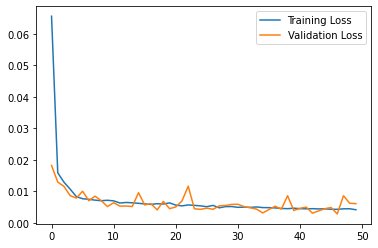

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


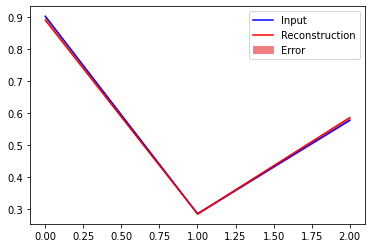

In [15]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(3), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


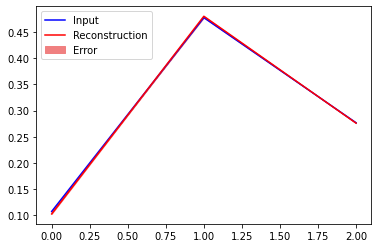

In [16]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(3), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


Detect anomalies by calculating the reconstruction lose of a fixed threshold.

Calculate the mean error for normal training examples to classify future anomalies if the error is greater than a StandDeviat of the train set.

Error of normal MODBUS in training set

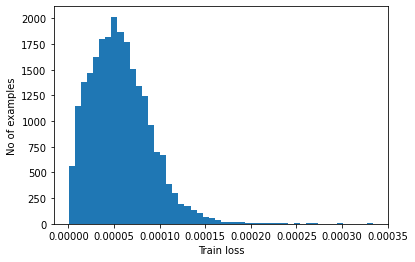

In [19]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mean_squared_error(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


Select a value a std greater from the mean

In [20]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  9.065027e-05


Error of abnormal MODBUS in test set

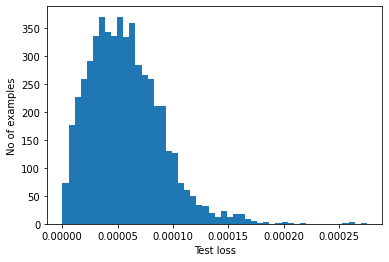

In [21]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mean_squared_error(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


Classify instance as abnormal if the reconstruction error is greater than the threshold

In [27]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mean_squared_error(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions))) #sensitivity
  print("F1 = {}".format(f1_score(labels, predictions)))
  print("ROC_AUC = {}".format(roc_auc_score(labels, predictions)))



In [29]:
# Results dont make sense give more weight to anomaly class in the learning process
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.37100504002371776
Precision = 0.31761115349934105
Recall = 0.8560478594129743
F1 = 0.4633208539917029
ROC_AUC = 0.5008790877474736
